# Lab:  Model Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain. In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces. In this lab, you will use model selection for performing some simple analysis on real neural signals. 

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Load MATLAB data
* Formulate models of different complexities using heuristic model selection
* Fit a linear model for the different model orders
* Select the optimal model via cross-validation

The last stage of the lab uses LASSO estimation for model selection.  If you are doing this part of the lab, you should review the concepts in [LASSO demonstration](./prostate.ipynb) on the prostate cancer  dataset.  

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the basic packages.

In [398]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  To make this lab easier, I have pre-processed the data slightly and placed it in the file `StevensonV2.mat`, which is a MATLAB file.  You will need to have this file downloaded in the directory you are working on.

Since MATLAB is widely-used, `python` provides method for loading MATLAB `mat` files.  We can use these commands to load the data as follows.

In [399]:
import scipy.io
mat_dict = scipy.io.loadmat('StevensonV2.mat')

The returned structure, `mat_dict`, is a dictionary with each of the MATLAB variables that were saved in the `.mat` file.  Use the `.keys()` method to list all the variables.

In [400]:
#TODO
mat_dict.keys()

dict_keys(['__header__', '__version__', '__globals__', 'Publication', 'timeBase', 'spikes', 'time', 'handVel', 'handPos', 'target', 'startBins', 'targets', 'startBinned'])

We extract two variables, `spikes` and `handVel`, from the dictionary `mat_dict`, which represent the recorded spikes per neuron and the hand velocity.  We take the transpose of the spikes data so that it is in the form time bins $\times$ number of neurons.  For the `handVel` data, we take the first component which is the motion in the $x$-direction.

In [401]:
X0 = mat_dict['spikes'].T
y0 = mat_dict['handVel'][0,:]

The `spikes` matrix will be a `nt x nneuron` matrix where `nt` is the number of time bins and `nneuron` is the number of neurons.  Each entry `spikes[k,j]` is the number of spikes in time bin `k` from neuron `j`.  Use the `shape` method to find `nt` and `nneuron` and print the values.

In [402]:
# TODO 
nt, nneuron = X0.shape
print("Number of time bins nt = {}, Number of Neuron nneuron = {}".format(nt, nneuron))

Number of time bins nt = 15536, Number of Neuron nneuron = 196


Now extract the `time` variable from the `mat_dict` dictionary.  Reshape this to a 1D array with `nt` components.  Each entry `time[k]` is the starting time of the time bin `k`.  Find the sampling time `tsamp` which is the time between measurements, and `ttotal` which is the total duration of the recording.

In [403]:
# TODO
t0 = np.array(mat_dict['time'])
time = t0.reshape(nt)
tsamp = time[1] - time[0]
ttotal=time[nt-1] - time[0]
print("tsamp = {}, ttotal = {}".format(tsamp, ttotal))

tsamp = 0.049999999999998934, ttotal = 776.75


## Linear fitting on all the neurons

First divide the data into training and test with approximately half the samples in each.  Let `Xtr` and `ytr` denote the training data and `Xts` and `yts` denote the test data.

In [404]:
# TODO
# Xtr = ...
# ytr = ...
# Xts = ...
# yts = ...
nsamp = X0.shape[0]
ntr = nsamp//2
nts = nsamp - ntr
Xtr = X0[:ntr, :]
ytr = y0[:ntr]
Xts = X0[ntr:, :]
yts = y0[ntr:]

Now, we begin by trying to fit a simple linear model using *all* the neurons as predictors.  To this end, use the `sklearn.linear_model` package to create a regression object, and fit the linear model to the training data.

In [405]:
import sklearn.linear_model

# TODO
regr = sklearn.linear_model.LinearRegression()
regr.fit(Xtr,ytr)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Measure and print the normalized RSS on the test data.  

In [406]:
# TODO
y_pred_test = regr.predict(Xts)
# RSS_test = ...
RSS_test = np.mean((y_pred_test-yts)**2/(np.std(yts)**2))
print("Normalized RSS = {0:f}".format(RSS_test))

Normalized RSS = 1889379842913849311232.000000


You should see that the test error is enormous -- the model does not generalize to the test data at all. 

## Linear Fitting  with Heuristic Model Selection

The above shows that we need a way to reduce the model complexity.  One simple idea is to select only the neurons that individually have a high correlation with the output.   

Write code which computes the coefficient of determination, $R^2_k$, for each neuron $k$.  Plot the $R^2_k$ values.  

You can use a for loop over each neuron, but if you want to make efficient code try to avoid the for loop and use [python broadcasting](../Basics/numpy_axes_broadcasting.ipynb).

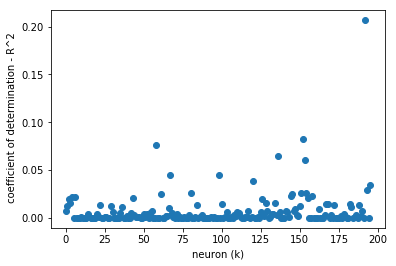

In [407]:
# TODO
# Rsq = ...
# plt.stem(...)
regr_loc = sklearn.linear_model.LinearRegression()
Rsq = np.zeros(nneuron)
#OSM = Output sample mean
OSM = np.mean((ytr-ym)**2)
for i in range (nneuron):
        x_data = Xtr[:,i]
        x_resh = x_data.reshape(-1,1)
        regr_loc.fit(x_resh,ytr)  
        y_pred_train = regr_loc.predict(x_resh)
        RSS = np.mean((y_pred_train-ytr)**2)
        Rsq[i] = 1-(RSS)/(OSM)
                   
plt.plot(Rsq,'o')
plt.xlabel('neuron (k)')
plt.ylabel(' coefficient of determination -R^2')                

We see that many neurons have low correlation and can probably be discarded from the model.    

Use the `np.argsort()` command to find the indices of the `d=100` neurons with the highest $R^2_k$ value.  Put the `d` indices into an array `Isel`.  Print the indices of the neurons with the 10 highest correlations.

In [408]:
d = 100  # Number of neurons to use

# TODO
# Isel = ...
# print("The neurons with the ten highest R^2 values = ...)
PN = Rsq.argsort()
Isel = PN[-100:]
print("The neurons with the ten highest R^2 values =", Isel[-10:])

The neurons with the ten highest R^2 values = [193 195 120  98  67 153 136  58 152 192]


Fit a model using only the `d` neurons selected in the previous step and print both the test RSS per sample and the normalized test RSS.

In [409]:
# TODO
b = Xtr[:,Isel]
regr_new = sklearn.linear_model.LinearRegression()
regr_new.fit(b,ytr)
yy_pred_test = regr_new.predict(Xts[:,Isel])
RSS_Per_sample = (yy_pred_test-yts)**2
for j in range(RSS_Per_sample.shape[0]):
    print("RSS for sample = {0:2d} is".format(j),RSS_Per_sample[j])
RSS_test_new = np.mean(RSS_Per_sample/(np.std(yts)**2))
print("Normalized Test RSS = {0:2f}".format(RSS_test_new))

RSS for sample =  0 is 0.00682647205383
RSS for sample =  1 is 0.01179745085
RSS for sample =  2 is 0.00803716119086
RSS for sample =  3 is 0.0189566473761
RSS for sample =  4 is 0.0202394438053
RSS for sample =  5 is 0.00978631901465
RSS for sample =  6 is 0.00591616483957
RSS for sample =  7 is 0.000956888536915
RSS for sample =  8 is 3.81254642086e-05
RSS for sample =  9 is 0.000743604139667
RSS for sample = 10 is 0.00248030088051
RSS for sample = 11 is 0.000126800546547
RSS for sample = 12 is 2.60896157376e-08
RSS for sample = 13 is 0.00157283933826
RSS for sample = 14 is 0.00713547148648
RSS for sample = 15 is 2.64748471524e-06
RSS for sample = 16 is 0.000184459205976
RSS for sample = 17 is 7.16442805922e-05
RSS for sample = 18 is 2.51692802939e-06
RSS for sample = 19 is 0.00116515940002
RSS for sample = 20 is 0.000808402483414
RSS for sample = 21 is 4.78277184984e-06
RSS for sample = 22 is 0.00138858428932
RSS for sample = 23 is 0.000199354056534
RSS for sample = 24 is 4.82200333

RSS for sample = 238 is 0.000106323967159
RSS for sample = 239 is 0.000429248124679
RSS for sample = 240 is 0.000227445605189
RSS for sample = 241 is 0.000298868062557
RSS for sample = 242 is 0.000277205750881
RSS for sample = 243 is 3.54434479713e-05
RSS for sample = 244 is 0.00319381983976
RSS for sample = 245 is 0.000265522505639
RSS for sample = 246 is 0.00164367402886
RSS for sample = 247 is 0.0091400429528
RSS for sample = 248 is 0.0104285805076
RSS for sample = 249 is 0.0291533780774
RSS for sample = 250 is 0.0311456064662
RSS for sample = 251 is 0.0346067668777
RSS for sample = 252 is 0.0230619894895
RSS for sample = 253 is 0.0110911697642
RSS for sample = 254 is 0.00401814484963
RSS for sample = 255 is 0.000515874489941
RSS for sample = 256 is 0.00366927124605
RSS for sample = 257 is 0.00522710918343
RSS for sample = 258 is 0.000110054972185
RSS for sample = 259 is 0.00061018847538
RSS for sample = 260 is 0.000130566581963
RSS for sample = 261 is 4.43838200401e-06
RSS for samp

RSS for sample = 1363 is 2.79311934659e-05
RSS for sample = 1364 is 0.000193589354458
RSS for sample = 1365 is 0.00010814471956
RSS for sample = 1366 is 0.000395254696335
RSS for sample = 1367 is 0.00105113190497
RSS for sample = 1368 is 0.0020306660857
RSS for sample = 1369 is 9.15380317164e-05
RSS for sample = 1370 is 0.000232234355887
RSS for sample = 1371 is 0.00189605448815
RSS for sample = 1372 is 9.62642909894e-05
RSS for sample = 1373 is 0.000383372664548
RSS for sample = 1374 is 0.0044234838604
RSS for sample = 1375 is 0.000370686893415
RSS for sample = 1376 is 0.000930140216506
RSS for sample = 1377 is 0.00316675412707
RSS for sample = 1378 is 2.85516074582e-05
RSS for sample = 1379 is 0.000209730965068
RSS for sample = 1380 is 0.000140753962988
RSS for sample = 1381 is 7.04860113198e-05
RSS for sample = 1382 is 0.000422261826557
RSS for sample = 1383 is 0.000125507544692
RSS for sample = 1384 is 2.96412458265e-05
RSS for sample = 1385 is 5.63906861771e-05
RSS for sample = 13

RSS for sample = 2420 is 0.00167182745612
RSS for sample = 2421 is 0.00271399750313
RSS for sample = 2422 is 0.000816206758193
RSS for sample = 2423 is 0.00135654692554
RSS for sample = 2424 is 3.24088061354e-05
RSS for sample = 2425 is 0.00349343335876
RSS for sample = 2426 is 0.00353455212588
RSS for sample = 2427 is 0.000430294994712
RSS for sample = 2428 is 3.06917736219e-05
RSS for sample = 2429 is 6.68645876692e-05
RSS for sample = 2430 is 0.000354366225217
RSS for sample = 2431 is 0.000240806663
RSS for sample = 2432 is 0.000275355628602
RSS for sample = 2433 is 0.000508483085868
RSS for sample = 2434 is 4.62152736765e-07
RSS for sample = 2435 is 0.000820207345713
RSS for sample = 2436 is 0.000642017716829
RSS for sample = 2437 is 0.000137148095676
RSS for sample = 2438 is 0.000332743662641
RSS for sample = 2439 is 0.000386983110105
RSS for sample = 2440 is 0.00137852946721
RSS for sample = 2441 is 0.00066270766572
RSS for sample = 2442 is 0.000703538849545
RSS for sample = 2443

RSS for sample = 3363 is 0.000286981251664
RSS for sample = 3364 is 0.00823565905768
RSS for sample = 3365 is 0.000521928228814
RSS for sample = 3366 is 0.000955578665177
RSS for sample = 3367 is 1.47230003146e-05
RSS for sample = 3368 is 0.000967396942797
RSS for sample = 3369 is 0.000866544513369
RSS for sample = 3370 is 0.000128584426197
RSS for sample = 3371 is 1.53701451544e-05
RSS for sample = 3372 is 0.0014586288305
RSS for sample = 3373 is 5.14217493298e-05
RSS for sample = 3374 is 0.00161432744434
RSS for sample = 3375 is 0.000148574229656
RSS for sample = 3376 is 0.000517061437214
RSS for sample = 3377 is 0.000309228482763
RSS for sample = 3378 is 0.00110040411975
RSS for sample = 3379 is 0.000110478896875
RSS for sample = 3380 is 0.00339197407591
RSS for sample = 3381 is 0.000198350414011
RSS for sample = 3382 is 1.06801773876e-09
RSS for sample = 3383 is 7.57368776954e-05
RSS for sample = 3384 is 0.000467369075998
RSS for sample = 3385 is 0.00048802865092
RSS for sample = 3

RSS for sample = 4454 is 2.61641927197e-05
RSS for sample = 4455 is 0.00302627099025
RSS for sample = 4456 is 0.000466506763637
RSS for sample = 4457 is 0.000692618782731
RSS for sample = 4458 is 0.00271419485586
RSS for sample = 4459 is 9.94292192905e-08
RSS for sample = 4460 is 1.95319856713e-05
RSS for sample = 4461 is 5.45940890923e-05
RSS for sample = 4462 is 0.00224788468294
RSS for sample = 4463 is 2.2671549671e-05
RSS for sample = 4464 is 0.00018142270971
RSS for sample = 4465 is 0.000617305699307
RSS for sample = 4466 is 0.00231243981026
RSS for sample = 4467 is 0.000190021591326
RSS for sample = 4468 is 0.000505766858775
RSS for sample = 4469 is 0.000258269830173
RSS for sample = 4470 is 7.74338765346e-06
RSS for sample = 4471 is 0.000129464320713
RSS for sample = 4472 is 0.0002025474968
RSS for sample = 4473 is 1.99832649549e-05
RSS for sample = 4474 is 6.60300884313e-05
RSS for sample = 4475 is 0.000483275809687
RSS for sample = 4476 is 6.38359859949e-05
RSS for sample = 44

RSS for sample = 5618 is 0.00019112545787
RSS for sample = 5619 is 0.00319081551833
RSS for sample = 5620 is 1.03652338044e-05
RSS for sample = 5621 is 0.000194859752632
RSS for sample = 5622 is 0.00114924195104
RSS for sample = 5623 is 0.0012545734192
RSS for sample = 5624 is 0.000715903800353
RSS for sample = 5625 is 0.0091821634755
RSS for sample = 5626 is 0.0202083065027
RSS for sample = 5627 is 0.0373995186309
RSS for sample = 5628 is 0.0132632649758
RSS for sample = 5629 is 0.0253464686012
RSS for sample = 5630 is 0.0258241067913
RSS for sample = 5631 is 0.00818072460612
RSS for sample = 5632 is 0.00247740893121
RSS for sample = 5633 is 0.00485669647768
RSS for sample = 5634 is 0.000452604533741
RSS for sample = 5635 is 0.00260663899434
RSS for sample = 5636 is 0.000158572084085
RSS for sample = 5637 is 0.000111144664851
RSS for sample = 5638 is 1.95609893314e-06
RSS for sample = 5639 is 8.02583978685e-05
RSS for sample = 5640 is 0.00212536043226
RSS for sample = 5641 is 0.000462

RSS for sample = 6856 is 0.000862963005107
RSS for sample = 6857 is 0.00444796672058
RSS for sample = 6858 is 0.0056988130941
RSS for sample = 6859 is 0.0215647842074
RSS for sample = 6860 is 0.022409719363
RSS for sample = 6861 is 0.00561510174838
RSS for sample = 6862 is 0.00364240757101
RSS for sample = 6863 is 0.00216235196719
RSS for sample = 6864 is 0.00229857482199
RSS for sample = 6865 is 0.00012943586282
RSS for sample = 6866 is 0.000219170100654
RSS for sample = 6867 is 5.21720348706e-05
RSS for sample = 6868 is 0.00052967727401
RSS for sample = 6869 is 0.000504229216155
RSS for sample = 6870 is 0.000464565610284
RSS for sample = 6871 is 0.00090248187679
RSS for sample = 6872 is 0.000922481326443
RSS for sample = 6873 is 0.0024915853307
RSS for sample = 6874 is 0.000106832487051
RSS for sample = 6875 is 0.00120697918446
RSS for sample = 6876 is 0.00377941657882
RSS for sample = 6877 is 0.00222265862633
RSS for sample = 6878 is 0.0005957931337
RSS for sample = 6879 is 0.000167

Create a scatter plot of the predicted vs. actual hand motion on the test data.  On the same plot, plot the line where `yts_hat = yts`.

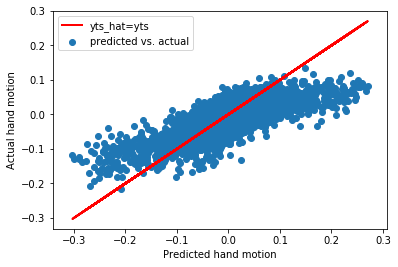

In [410]:
# TODO
plt.scatter(yts,yy_pred_test)
yts_hat = yts
plt.plot(yts, yts_hat,'r-',linewidth=2)
plt.xlabel('Predicted hand motion')
plt.ylabel('Actual hand motion')
plt.legend(['yts_hat=yts','predicted vs. actual', 'loc = upper left'])

## Using K-fold cross validation for the optimal number of neurons

In the above, we fixed `d=100`.  We can use cross validation to try to determine the best number of neurons to use.  Try model orders with `d=10,20,...,190`.  For each value of `d`, use K-fold validation with 10 folds to estimate the test RSS.  For a data set this size, each fold will take a few seconds to compute, so it may be useful to print the progress.

In [411]:
import  sklearn.model_selection 

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)

# Model orders to be tested
dtest = np.arange(10,200,10)
nd = len(dtest)
# TODO. 
RSSts = np.zeros((nd,nfold))
lin_reg = sklearn.linear_model.LinearRegression()

for ifold, ind in enumerate(kf.split(X0)):
    Itr, Its = ind
    
    X_tr = X0[Itr,:]
    y_tr = y0[Itr]
    X_ts = X0[Its,:]
    y_ts = y0[Its]
        
    for it in range(nd):
        Indx = dtest[it]
        imp = PN[-1*Indx:]
    
        x_tr_new = X_tr[:,imp]
        lin_reg.fit(x_tr_new,y_tr)
        x_ts_new = X_ts[:,imp]
        y_ts_pred_new = lin_reg.predict(x_ts_new)
        RSSts[it,ifold] = np.mean((y_ts_pred_new-y_ts)**2)
        print("Test RSS for {} fold is {}".format(ifold, RSSts[it, ifold]))

Test RSS for 0 fold is 0.00203575898392804
Test RSS for 0 fold is 0.0018801740425203768
Test RSS for 0 fold is 0.0018353800854091253
Test RSS for 0 fold is 0.0017796153928473339
Test RSS for 0 fold is 0.0017460694985847844
Test RSS for 0 fold is 0.001733283765308924
Test RSS for 0 fold is 0.0017104993181511006
Test RSS for 0 fold is 0.0016896857181399598
Test RSS for 0 fold is 0.0016632441692877305
Test RSS for 0 fold is 0.0016629262132559703
Test RSS for 0 fold is 0.001662683200895358
Test RSS for 0 fold is 0.0016696839718957635
Test RSS for 0 fold is 0.001607686077347182
Test RSS for 0 fold is 0.0016067088270600534
Test RSS for 0 fold is 0.0016075572581059838
Test RSS for 0 fold is 0.0016001158979514463
Test RSS for 0 fold is 0.0016017542646720971
Test RSS for 0 fold is 0.0016019838490023315
Test RSS for 0 fold is 0.0016014746848947538
Test RSS for 1 fold is 0.0018595353024515543
Test RSS for 1 fold is 0.0017212808498092219
Test RSS for 1 fold is 0.0016937833356747386
Test RSS for 1 

Test RSS for 9 fold is 0.0015727310951849961
Test RSS for 9 fold is 0.0015657767207790702
Test RSS for 9 fold is 0.0015678562817818958
Test RSS for 9 fold is 0.0015698146523638584
Test RSS for 9 fold is 0.0015676748933827714


Compute the RSS test mean and standard error and plot them as a function of the model order `d` using the `plt.errorbar()` method. 

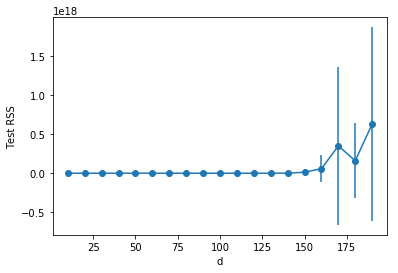

In [412]:
# TOD
RSSts_mean = np.mean(RSSts,axis=1) 
RSSts_err = np.std(RSSts,axis=1) 

plt.errorbar(dtest,RSSts_mean, yerr = RSSts_err, fmt='o-')
plt.xlabel('d')
plt.ylabel('Test RSS')

Find the optimal order using the one standard error rule. Print the optimal value of `d` and the mean test RSS per sample at the optimal `d`.  

In [413]:
# TODO
imin = np.argmin(RSSts_mean)
RSSts_tgt = RSSts_mean[imin] + RSSts_err[imin]
d_min = dtest[imin]
I = np.where(RSSts_mean < RSSts_tgt)[0]
iopt = I[-1]
d_opt = dtest[iopt]
print("Optimal d = %d" % d_opt)

# Create a k-fold object
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
lin_reg = sklearn.linear_model.LinearRegression()

for ifold, ind in enumerate(kf.split(X0)):
    Itr, Its = ind
    
    X_tr = X0[Itr,:]
    y_tr = y0[Itr]
    X_ts = X0[Its,:]
    y_ts = y0[Its]
    if ifold == 0:
        nSample = y_ts.shape[0]
        RSSts_dopt = np.zeros((nfold, y_ts.shape[0]))    
    Indx = d_opt
    imp = PN[-1*Indx:]
    x_tr_new = X_tr[:,imp]
    lin_reg.fit(x_tr_new,y_tr)
    x_ts_new = X_ts[:,imp]
    y_ts_pred_new = lin_reg.predict(x_ts_new)
    PRSS = (y_ts_pred_new-y_ts)**2
    nSampleMin = min(nSample, PRSS.shape[0]) 
    RSSts_dopt[ifold, 0:nSampleMin] = PRSS[0:nSampleMin]

PerSampleMean = np.mean(RSSts_dopt, axis=0)      
for i in range(PerSampleMean.shape[0]):
    print("Test mean RSS per sample for sample {} at optimal dopt {}  is {}".format(i, d_opt, PerSampleMean[i]))


Optimal d = 140
Test mean RSS per sample for sample 0 at optimal dopt 140  is 0.002157830143810402
Test mean RSS per sample for sample 1 at optimal dopt 140  is 0.0008739527546807156
Test mean RSS per sample for sample 2 at optimal dopt 140  is 0.0007998291999693003
Test mean RSS per sample for sample 3 at optimal dopt 140  is 0.0017793723299146455
Test mean RSS per sample for sample 4 at optimal dopt 140  is 0.0009374248526581169
Test mean RSS per sample for sample 5 at optimal dopt 140  is 0.0011146294585245812
Test mean RSS per sample for sample 6 at optimal dopt 140  is 0.0012510163662649307
Test mean RSS per sample for sample 7 at optimal dopt 140  is 0.0017869312651120014
Test mean RSS per sample for sample 8 at optimal dopt 140  is 0.0031856963004492068
Test mean RSS per sample for sample 9 at optimal dopt 140  is 0.0010088696658071368
Test mean RSS per sample for sample 10 at optimal dopt 140  is 0.0012279485649242452
Test mean RSS per sample for sample 11 at optimal dopt 140  

Test mean RSS per sample for sample 739 at optimal dopt 140  is 0.0004524564992358586
Test mean RSS per sample for sample 740 at optimal dopt 140  is 0.0030540306463405485
Test mean RSS per sample for sample 741 at optimal dopt 140  is 0.0014273724400947615
Test mean RSS per sample for sample 742 at optimal dopt 140  is 0.0011679864099546854
Test mean RSS per sample for sample 743 at optimal dopt 140  is 0.0007906473044612516
Test mean RSS per sample for sample 744 at optimal dopt 140  is 0.002045429677072553
Test mean RSS per sample for sample 745 at optimal dopt 140  is 0.0016402381313689845
Test mean RSS per sample for sample 746 at optimal dopt 140  is 0.00041439482633195393
Test mean RSS per sample for sample 747 at optimal dopt 140  is 0.0019337082518978948
Test mean RSS per sample for sample 748 at optimal dopt 140  is 0.0007072924183455301
Test mean RSS per sample for sample 749 at optimal dopt 140  is 0.0011543726657272043
Test mean RSS per sample for sample 750 at optimal dop

## Using LASSO regression

Instead of using the above heuristic to select the variables, we can use LASSO regression.  

First use the `preprocessing.scale` method to standardize the data matrix `X0`.  Store the standardized values in `Xs`.  You do not need to standardize the response.  For this data, the `scale` routine may throw a warning that you are converting data types.  That is fine.

In [414]:
from sklearn import preprocessing
# TODO
Xs = preprocessing.scale(X0)


C:\Users\Pooja\Anaconda3\lib\site-packages\sklearn\utils\validation.py:429: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, _DataConversionWarning)


Now, use the LASSO method to fit a model.  Use cross validation to select the regularization level `alpha`.  Use `alpha` values logarithmically spaced from `1e-5` to `0.1`, and use 10 fold cross validation.  

In [415]:
# TODO
nfold = 10
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
model = sklearn.linear_model.Lasso(warm_start=True)
nalpha = 50
alphas = np.logspace(-5,-1,nalpha)
mse = np.zeros((nalpha,nfold))

for ifold, ind in enumerate(kf.split(Xs)):
    Itr, Its = ind
    
    X_tr = Xs[Itr,:]
    y_tr = y0[Itr]
    X_ts = Xs[Its,:]
    y_ts = y0[Its]
    
    for ia, a in enumerate(alphas):
        model.alpha = a
        model.fit(X_tr,y_tr)
        y_ts_pred = model.predict(X_ts)
        mse[ia,ifold] = np.mean((y_ts_pred-y_ts)**2)
mse_mean = np.mean(mse,axis=1) #row wise mean
mse_std = np.std(mse,axis=1)

Plot the mean test RSS and test RSS standard error with the `plt.errorbar` plot.

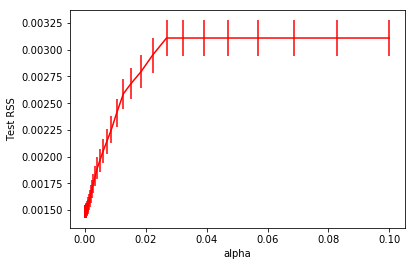

In [416]:
# TODO
plt.errorbar(alphas,mse_mean, yerr = mse_std, fmt='r-')
plt.xlabel('alpha')
plt.ylabel('Test RSS')

Find the optimal `alpha` and mean test RSS using the one standard error rule.

In [417]:
# TODO
imin = np.argmin(mse_mean)
mse_tgt = mse_mean[imin] + mse_std[imin]
alpha_min = alphas[imin]
I = np.where(mse_mean < mse_tgt)[0]
iopt = I[-1]
alpha_opt = alphas[iopt]
print("Optimal alpha = %f" % alpha_opt)

Optimal alpha = 0.000910


Using the optimal alpha, recompute the predicted response variable on the whole data.  Plot the predicted vs. actual values.

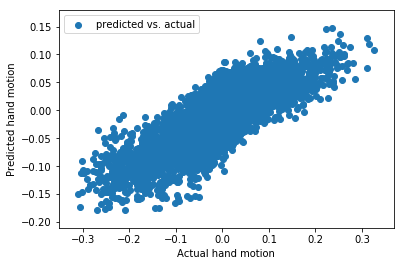

In [418]:
# TODO
model.alpha = alpha_opt
model.fit(Xs,y0)
y_ts_pred = model.predict(Xs)
plt.scatter(y0,y_ts_pred)
plt.ylabel('Predicted hand motion')
plt.xlabel('Actual hand motion')
plt.legend(['predicted vs. actual', 'loc = upper left'])

## More Fun

You can play around with this and many other neural data sets.  Two things that one can do to further improve the quality of fit are:
* Use more time lags in the data.  Instead of predicting the hand motion from the spikes in the previous time, use the spikes in the last few delays.
* Add a nonlinearity.  You should see that the predicted hand motion differs from the actual for high values of the actual.  You can improve the fit by adding a nonlinearity on the output.  A polynomial fit would work well here.

You do not need to do these, but you can try them if you like.